In [12]:
!pip install idx2numpy
!pip install scikit-learn

In [13]:
import os
import zipfile
import idx2numpy
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# **Question 1**


In [16]:
file_path = "/content/data.zip"

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(".")

train_images_path = "train/train-images-idx3-ubyte"
train_labels_path = "train/train-labels-idx1-ubyte"
test_images_path = "test/test-images-idx3-ubyte"
test_labels_path = "test/test-labels-idx1-ubyte"

train_images = idx2numpy.convert_from_file(train_images_path)
train_labels = idx2numpy.convert_from_file(train_labels_path)
test_images = idx2numpy.convert_from_file(test_images_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)

print(f'Training images shape {train_images.shape}')
print(f'Training labels shape {train_labels.shape}')
print(f'Test images shape {test_images.shape}')
print(f'Test labels shape {test_labels.shape}')

Training images shape (60000, 28, 28)
Training labels shape (60000,)
Test images shape (10000, 28, 28)
Test labels shape (10000,)


In [17]:
mean_train = np.mean(train_images)/255
std_train = np.std(train_images)/255

mean_test = np.mean(test_images)/255
std_test = np.std(test_images)/255

print(f'Train images mean = {mean_train}')
print(f'Train images std = {std_train}')
print(f'Test images mean = {mean_test}')
print(f'Test images std = {std_test}')

Train images mean = 0.1306604762738429
Train images std = 0.30810780385646264
Test images mean = 0.13251460584233693
Test images std = 0.3104802479305351


In [18]:
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean_train, std = std_train)
])

In [19]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [20]:
full_train_dataset = CustomDataset(train_images, train_labels, transform)
test_dataset = CustomDataset(test_images, test_labels, transform)

train_dataset, val_dataset = train_test_split(full_train_dataset, test_size = 0.2, random_state = 42)

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_images, batch_size=64, shuffle=False)

print(f'Training images length = {len(train_dataset)}')
print(f'Validation images length = {len(val_dataset)}')
print(f'Test images length = {len(test_dataset)}')

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Training images length = 48000
Validation images length = 12000
Test images length = 10000


In [21]:
one_hot_labels = F.one_hot(torch.tensor(test_labels, dtype = torch.long), num_classes=10)
print(one_hot_labels)

tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


# **Question 2**

In [22]:
train_images = np.array([item[0].numpy().flatten() for item in train_dataset])
train_labels = np.array([item[1] for item in train_dataset])

test_images = np.array([item[0].numpy().flatten() for item in test_dataset])
test_labels = np.array([item[1] for item in test_dataset])

model = LogisticRegression(max_iter=1000)
model.fit(train_images, train_labels)
test_pred = model.predict(test_images)

accuracy = accuracy_score(test_labels, test_pred)
precision = precision_score(test_labels, test_pred, average='weighted')
recall = recall_score(test_labels, test_pred, average='weighted')
f1 = f1_score(test_labels, test_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9193
Precision: 0.91906972268138
Recall: 0.9193
F1 Score: 0.9190867474376774


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01],  # Regularization parameter
    'penalty': ['l2'],  # Regularization type
    'solver': ['saga'],  # Solver for optimization
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_images, train_labels)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Best Hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Best Accuracy: 0.9185208333333333


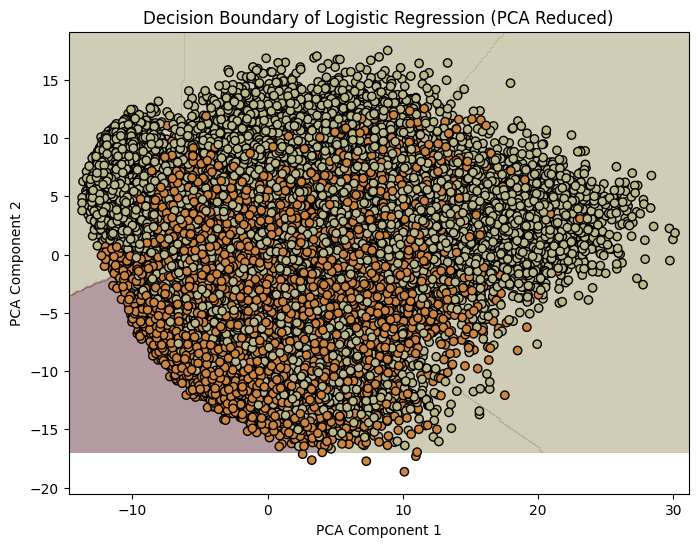

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


pca = PCA(n_components=2)
train_images_2d = pca.fit_transform(train_images)
test_images_2d = pca.fit_transform(test_images)

model_2d = LogisticRegression(max_iter=1000)
model_2d.fit(train_images_2d, train_labels)

x_min, x_max = train_images_2d[:, 0].min() -1, train_images_2d[:,0].max() + 1
y_min, y_max = test_images_2d[:, 1].min() - 1, test_images_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Predict labels for each point in the grid
z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
cmap_background = ListedColormap(["#B2AC88", "#835963"])  # Light red & blue
cmap_points = ListedColormap(["#BCB88A", "#cd853f"])  # Red & blue

plt.contourf(xx, yy, z, cmap=cmap_background, alpha=0.6)  # Decision boundary
plt.scatter(train_images_2d[:, 0], train_images_2d[:, 1], c=train_labels, cmap=cmap_points, edgecolors="k")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Decision Boundary of Logistic Regression (PCA Reduced)")
plt.show()